## National Water Model Example

This notebook gives a brief introduction to the National Water Model data available from Azure Blob Storage. It uses [xarray](https://xarray.pydata.org/) and [adlfs](https://fsspec.github.io/adlfs) to load the NetCDF files and visualize the data. We'll work with the raw NetCDF data pushed to azure by [NODD](https://www.noaa.gov/information-technology/open-data-dissemination).

The goals of this notebook are to learn what NWM data are available on Azure, and to build a bit of familiarity with the compute environment you're in.

In [1]:
import adlfs
import azure.storage.blob
import planetary_computer
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
import pyproj
import contextily
import planetary_computer
import pystac_client
from IPython.display import Image
import odc.stac

In [2]:
fs = adlfs.AzureBlobFileSystem(
    "noaanwm", credential=planetary_computer.sas.get_token("noaanwm", "nwm").token
)

A new set of files is produced every few hours. This example uses the files from 2023-01-23T00:00. We'll load a short-range forecast for the Continental United States.

In [3]:
prefix = "nwm/nwm.20230123"

ds = xr.open_dataset(
    fs.open(f"{prefix}/short_range/nwm.t00z.short_range.land.f001.conus.nc")
)
display(ds)

<xarray.Dataset>
Dimensions:         (time: 1, reference_time: 1, x: 4608, y: 3840)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-23T01:00:00
  * reference_time  (reference_time) datetime64[ns] 2023-01-23
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    crs             |S1 ...
    SNOWH           (time, y, x) float64 ...
    SNEQV           (time, y, x) float64 ...
    FSNO            (time, y, x) float64 ...
    ACCET           (time, y, x) float64 ...
    SOILSAT_TOP     (time, y, x) float64 ...
    SNOWT_AVG       (time, y, x) float64 ...
Attributes:
    TITLE:                      OUTPUT FROM NWM v2.2
    model_initialization_time:  2023-01-23_00:00:00
    model_output_valid_time:    2023-01-23_01:00:00
    model_total_valid_times:    18
    Conventions:                CF-1.6
    code_version:               v5.2.0-beta2
    NWM_version_number:         v2.2
    model_output_type:          land
    model_configuration:        short_range
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic

We could have chosen a number of other products that `short_range.land` for the CONUS. https://planetarycomputer.microsoft.com/dataset/storage/noaa-nw has a full list of products available in Azure Blob Storage.

Let's load up the `SOILSAT_TOP` data variable.

In [4]:
soil_saturation = ds["SOILSAT_TOP"].load()

And make a pretty picture

[Text(0.5, 1.0, 'Soil saturation fraction')]

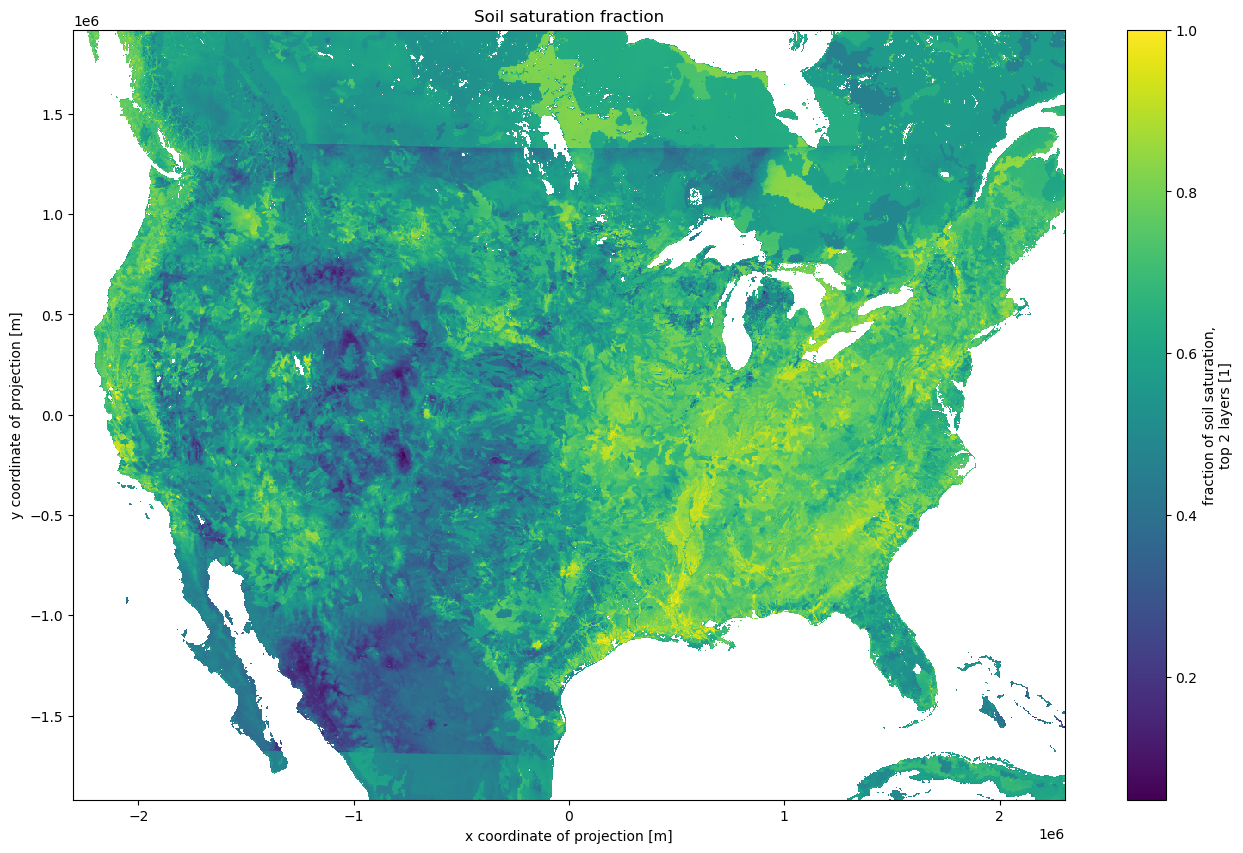

In [5]:
fig, ax = plt.subplots(figsize=(16, 10))

soil_saturation.coarsen(x=4, y=4, boundary="trim").mean().plot(ax=ax)
ax.set(title="Soil saturation fraction")

Similar files are available for different forecast hours (`f001`, `f002`, ..., `f018`)

### Exercise: Make a similar plot for the same datetime's 18-hour forecast of `ACCET`

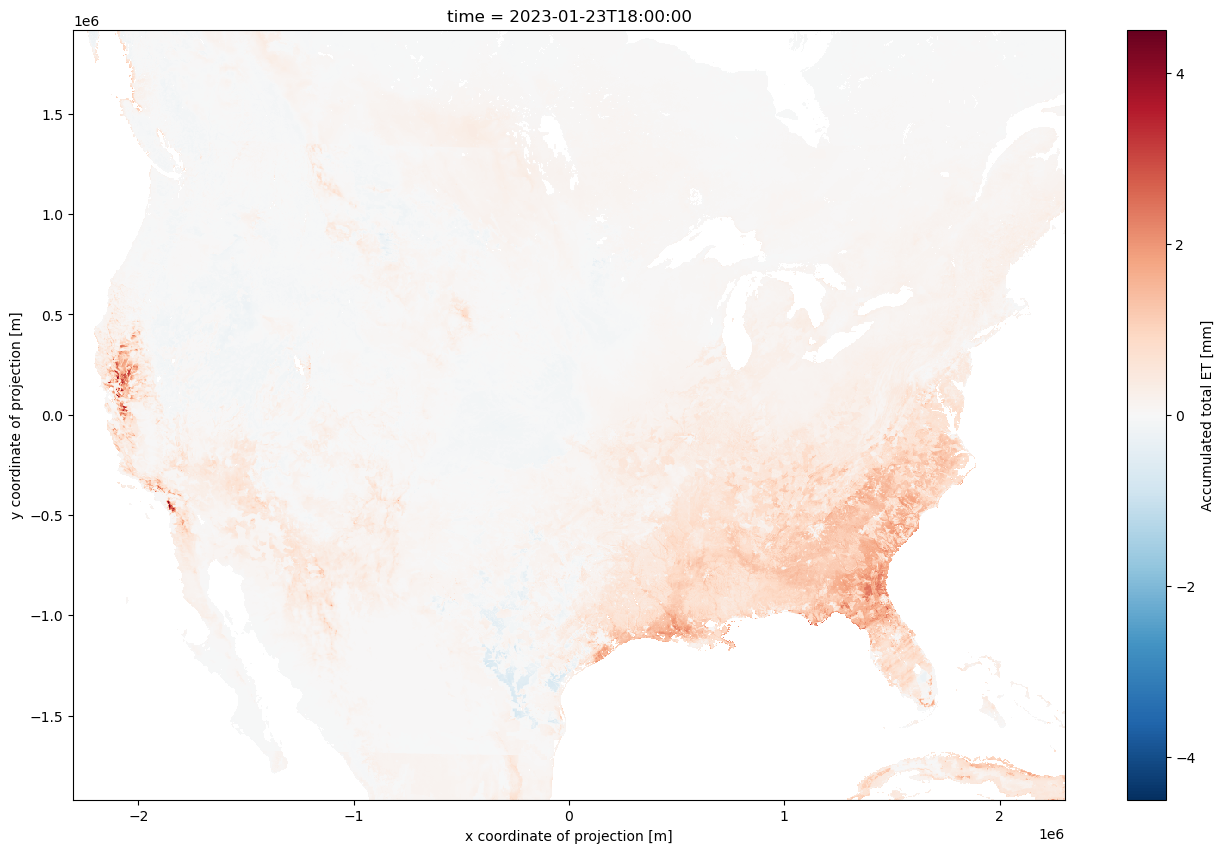

In [6]:
accet = xr.open_dataset(
    fs.open(f"{prefix}/short_range/nwm.t00z.short_range.land.f018.conus.nc")
)["ACCET"].load()

fig, ax = plt.subplots(figsize=(16, 10))
accet.coarsen(x=4, y=4, boundary="trim").mean().plot(ax=ax);

## Reservoir Data

These forecasts also include data on channel routing, terrain routing, and reservoir output. The reservoir data can be converted from the NetCDF data model to a tabular data strcture.

In [7]:
reservoir = xr.open_dataset(
    fs.open("nwm/nwm.20230123/short_range/nwm.t00z.short_range.reservoir.f001.conus.nc")
).load()
reservoir

<xarray.Dataset>
Dimensions:                      (time: 1, reference_time: 1, feature_id: 5783)
Coordinates:
  * time                         (time) datetime64[ns] 2023-01-23T01:00:00
  * reference_time               (reference_time) datetime64[ns] 2023-01-23
  * feature_id                   (feature_id) int32 491 531 ... 1021092845
    latitude                     (feature_id) float32 46.18 46.16 ... 44.59
    longitude                    (feature_id) float32 -68.38 -68.45 ... -73.31
Data variables:
    crs                          |S1 b''
    reservoir_type               (feature_id) float64 1.0 1.0 1.0 ... 1.0 1.0
    reservoir_assimilated_value  (feature_id) float32 nan nan nan ... nan nan
    water_sfc_elev               (feature_id) float32 206.2 247.9 ... 42.85
    inflow                       (feature_id) float64 0.41 0.04 ... 352.5
    outflow                      (feature_id) float64 0.56 0.39 ... 347.0
Attributes:
    TITLE:                      OUTPUT FROM NWM v2.2
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2023-01-23_00:00:00
    station_dimension:          lake_id
    model_output_valid_time:    2023-01-23_01:00:00
    model_total_valid_times:    18
    Conventions:                CF-1.6
    code_version:               v5.2.0-beta2
    NWM_version_number:         v2.2
    model_output_type:          reservoir
    model_configuration:        short_range

In [8]:
crs = pyproj.CRS.from_cf(reservoir.crs.attrs)

df = reservoir.drop("crs").to_dataframe()
geometry = geopandas.points_from_xy(df.longitude, df.latitude, crs=crs)

gdf = geopandas.GeoDataFrame(df, geometry=geometry)
gdf.head()

reservoir_type   
time                reference_time feature_id                   
2023-01-23 01:00:00 2023-01-23     491                    1.0  \
                                   531                    1.0   
                                   747                    1.0   
                                   759                    1.0   
                                   1581                   1.0   

                                               reservoir_assimilated_value   
time                reference_time feature_id                                
2023-01-23 01:00:00 2023-01-23     491                                 NaN  \
                                   531                                 NaN   
                                   747                                 NaN   
                                   759                                 NaN   
                                   1581                                NaN   

                                                latitude  longitude   
time                reference_time feature_id                         
2023-01-23 01:00:00 2023-01-23     491         46.183273 -68.379036  \
                                   531         46.161163 -68.454887   
                                   747         46.034088 -68.064995   
                                   759         46.022385 -68.162132   
                                   1581        45.648441 -67.937202   

                                               water_sfc_elev  inflow   
time                reference_time feature_id                           
2023-01-23 01:00:00 2023-01-23     491             206.240295    0.41  \
                                   531             247.883514    0.04   
                                   747             190.345016    0.02   
                                   759             165.124863    0.00   
                                   1581            130.215378    0.76   

                                               outflow   
time                reference_time feature_id            
2023-01-23 01:00:00 2023-01-23     491            0.56  \
                                   531            0.39   
                                   747            0.12   
                                   759            0.17   
                                   1581           0.96   

                                                                 geometry  
time                reference_time feature_id                              
2023-01-23 01:00:00 2023-01-23     491         POINT (-68.37904 46.18327)  
                                   531         POINT (-68.45489 46.16116)  
                                   747         POINT (-68.06499 46.03409)  
                                   759         POINT (-68.16213 46.02238)  
                                   1581        POINT (-67.93720 45.64844)

Which can also be visualized.

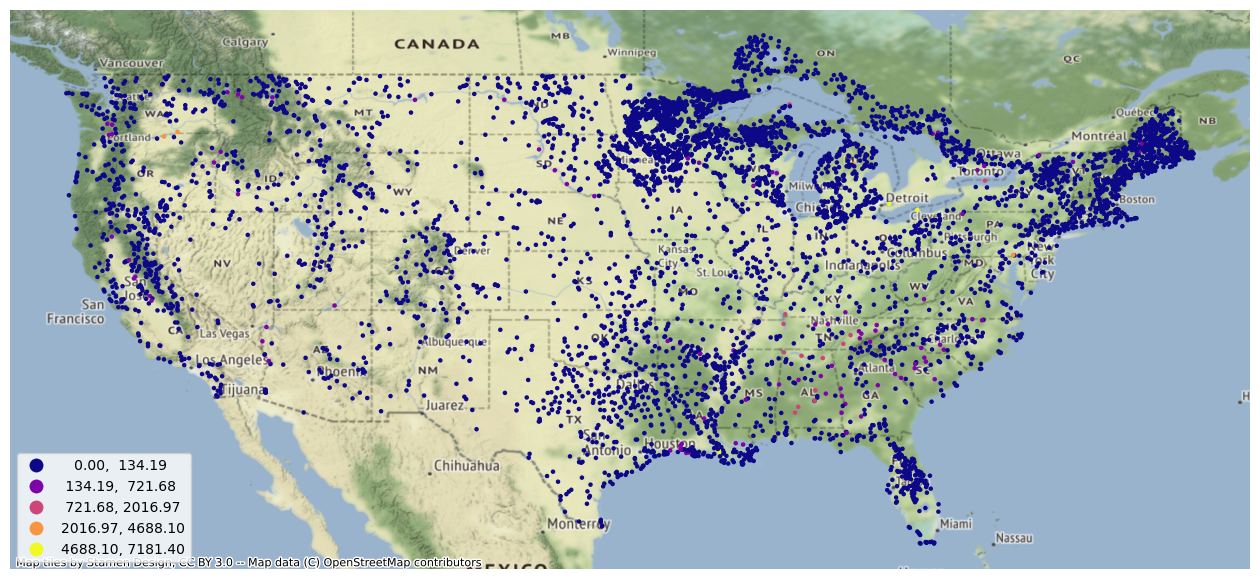

In [9]:
fig, ax = plt.subplots(figsize=(16, 12))

gdf[["inflow", "geometry"]].plot(
    column="inflow",
    scheme="NaturalBreaks",
    markersize=5,
    legend=True,
    ax=ax,
    cmap="plasma",
)
contextily.add_basemap(ax, crs=str(gdf.crs))

ax.set_axis_off()

## Other products

Other kinds data are available under each date's prefix. Some sub-folders different kinds of data (forcings, long- and medium-range forecasts, etc.) and some cover different regions (Hawaii and Puerto Rico).

In [10]:
fs.ls(prefix)

['nwm/nwm.20230123/analysis_assim',
 'nwm/nwm.20230123/analysis_assim_extend',
 'nwm/nwm.20230123/analysis_assim_extend_no_da',
 'nwm/nwm.20230123/analysis_assim_hawaii',
 'nwm/nwm.20230123/analysis_assim_hawaii_no_da',
 'nwm/nwm.20230123/analysis_assim_long',
 'nwm/nwm.20230123/analysis_assim_long_no_da',
 'nwm/nwm.20230123/analysis_assim_no_da',
 'nwm/nwm.20230123/analysis_assim_puertorico',
 'nwm/nwm.20230123/analysis_assim_puertorico_no_da',
 'nwm/nwm.20230123/forcing_analysis_assim',
 'nwm/nwm.20230123/forcing_analysis_assim_extend',
 'nwm/nwm.20230123/forcing_analysis_assim_hawaii',
 'nwm/nwm.20230123/forcing_analysis_assim_puertorico',
 'nwm/nwm.20230123/forcing_medium_range',
 'nwm/nwm.20230123/forcing_short_range',
 'nwm/nwm.20230123/forcing_short_range_hawaii',
 'nwm/nwm.20230123/forcing_short_range_puertorico',
 'nwm/nwm.20230123/long_range_mem1',
 'nwm/nwm.20230123/long_range_mem2',
 'nwm/nwm.20230123/long_range_mem3',
 'nwm/nwm.20230123/long_range_mem4',
 'nwm/nwm.20230123

## Quick Planetary Computer Intro

To read the datasets so far, we're having to deal with files and paths. This isn't the end of the world for the National Water Model, which produces files at well-known timestamps with well-known names, but it's certainly not as convenient as dealying with *concepts* (I want the 3-hour short-range forecast from the 2023-03-01T00:00:00 run over Hawaii).

With the [Planetary Computer](https://planetarycomputer.microsoft.com/), we're helping to make the data queryable and easier to access. In addition to hosting raw data, the Planetary Computer provides a [STAC](https://stacspec.org/) API for querying the data. This can be invaluable for certain use-cases.

For example, say you needed to grab all of the [Sentinel-2 L2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) imagery over Wyoming for July 2023. If you *just* had file paths, youd be dealing with a bunch of files like

```
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/T/BG/2022/07/01/S2A_MSIL2A_20220701T180931_N0400_R084_T13TBG_20220702T072856.SAFE/GRANULE/L2A_T13TBG_A036689_20220701T181502/IMG_DATA/R60m/T13TBG_20220701T180931_B01_60m.tif
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/T/BG/2022/07/01/S2A_MSIL2A_20220701T180931_N0400_R084_T13TBG_20220702T072856.SAFE/GRANULE/L2A_T13TBG_A036689_20220701T181502/IMG_DATA/R60m/T13TBG_20220701T180931_B02_60m.tif
...
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/12/T/YN/2022/07/01/S2A_MSIL2A_20220701T180931_N0400_R084_T12TYN_20220702T080209.SAFE/GRANULE/L2A_T12TYN_A036689_20220701T181502/IMG_DATA/R60m/T12TYN_20220701T180931_B03_60m.tif
```

And there's hundreds of thousands of files like that you'd have to comb through to find what you want. With STAC, finding the data you want is a single API call away.

In [11]:
# Load up the Planetary Computer's catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
# Search by space, time, and other properties
search = catalog.search(
    collections="sentinel-2-l2a",
    bbox=[-111, 41.02, -105.00, 45.00],
    datetime="2022-07-01/2022-07-31",
    query={"eo:cloud_cover": {"lt": 10}},
    sortby="datetime",
)

That search is very fast. And loading the STAC items into memory is fast too (they're just JSON metadata)

In [12]:
items = search.item_collection()
len(items)

240

We can inspect the items, by looking at the footprints for example.

In [13]:
df = geopandas.GeoDataFrame.from_features(items, crs="epsg:4326")
df.explore(style_kwds={"fillOpacity": 0.1})

And we can use the Planetary Computer's `data` API to quickly visualize an asset:

In [14]:
Image(url=items[3].assets["rendered_preview"].href)

And with one more function call, we can build an xarray Dataset

In [15]:
ds = odc.stac.load(
    items, bands=["B01", "B02", "B03"], crs=items[0].properties["proj:epsg"], chunks={}
)
ds

<xarray.Dataset>
Dimensions:      (y: 61601, x: 71804, time: 24)
Coordinates:
  * y            (y) float64 5.102e+06 5.102e+06 ... 4.486e+06 4.486e+06
  * x            (x) float64 -1.083e+05 -1.082e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2022-07-01T18:09:31.024000 ... 2022-07...
Data variables:
    B01          (time, y, x) float32 dask.array<chunksize=(1, 61601, 71804), meta=np.ndarray>
    B02          (time, y, x) float32 dask.array<chunksize=(1, 61601, 71804), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 61601, 71804), meta=np.ndarray>

While STAC metadata isn't *as* important for model output data stored as HDF5 or Zarr (which tends to be a bit more predictable and "self-describing"), it's still very convenient. Check out this [CMIP6](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc0#Example-Notebook) example for a demonstration.

## Cleanup

Now, stop this notebook kernel (`Kernel > Shut Down Kernel` or hit `0` a bunch of times) to free up memory.

Next up, we'll look at some [Problems](02-problems.ipynb).